In [2]:
#import required libraries
from sklearn.preprocessing import MinMaxScaler
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import learning_curve, GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


The first thing that must be done is import the required functions from keras and scikit learn. The MinMaxScaler function scales the variables to values between 0 and 1, while keras function sequential tells the processor that our model is sequential. the dense and dropout functions allow us to ..., while lstm is self explanatory; this is the basis for our entire model. 

In [3]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In this cell, I'm importing pandas and numpy, as well as matplotlib in order to plot our predicted data and visualize its effectiveness in comparison to the actual data. 

In [4]:
#read the file
df = pd.read_csv('ucsbdata.csv')

#print the head
df.head()

,Index,R,US10YR,EPS,PER,OPEN,HIGH,LOW,CLOSE,BDIY,...,MYSTERYVAR3,TOM,HULBERTSENTIMENT,BUBBLE,CASH,DEBT,DIVIDEND,RETURN,STOCKS,WAR
0,1952-01-02,NaN,NaN,2.44,9.754098,23.80,23.80,23.80,23.80,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1952-01-03,NaN,NaN,2.44,9.786885,23.88,23.88,23.88,23.88,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1952-01-04,NaN,NaN,2.44,9.803279,23.92,23.92,23.92,23.92,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1952-01-07,NaN,NaN,2.44,9.799180,23.91,23.91,23.91,23.91,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1952-01-08,NaN,NaN,2.44,9.762295,23.82,23.82,23.82,23.82,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we import the data that we will use to teach the lstm model. Our variables are ..., ..., selected because we have found those to be the most important predictors. 

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Closing Price History')

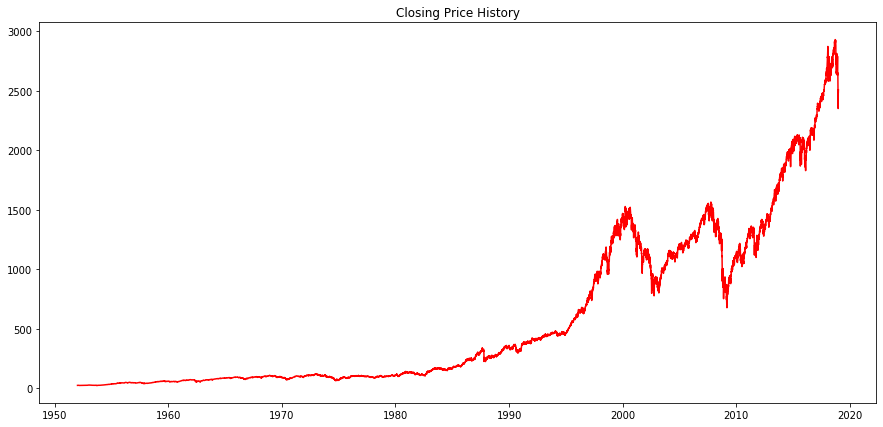

In [5]:
#setting index as date
df['DATE'] = pd.to_datetime(df.Index, format='%Y-%m-%d')
df.index = df.DATE

#plot
plt.figure(figsize=(15,7))
plt.plot(df['CLOSE'], 'r')
plt.title("Closing Price History")

In [32]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['DATE', 'CLOSE'])
for i in range(0,len(data)):
    new_data['DATE'][i] = data['DATE'][i]
    new_data['CLOSE'][i] = data['CLOSE'][i]

#setting index
new_data.index = new_data.DATE
new_data.drop('DATE', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:13491,:]
valid = dataset[13491:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In this cell we begin the setup to actually run the LSTM. 

In [25]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 4527/13431 [=========>....................] - ETA: 41:23 - loss: 2.0813e-04

KeyboardInterrupt: 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


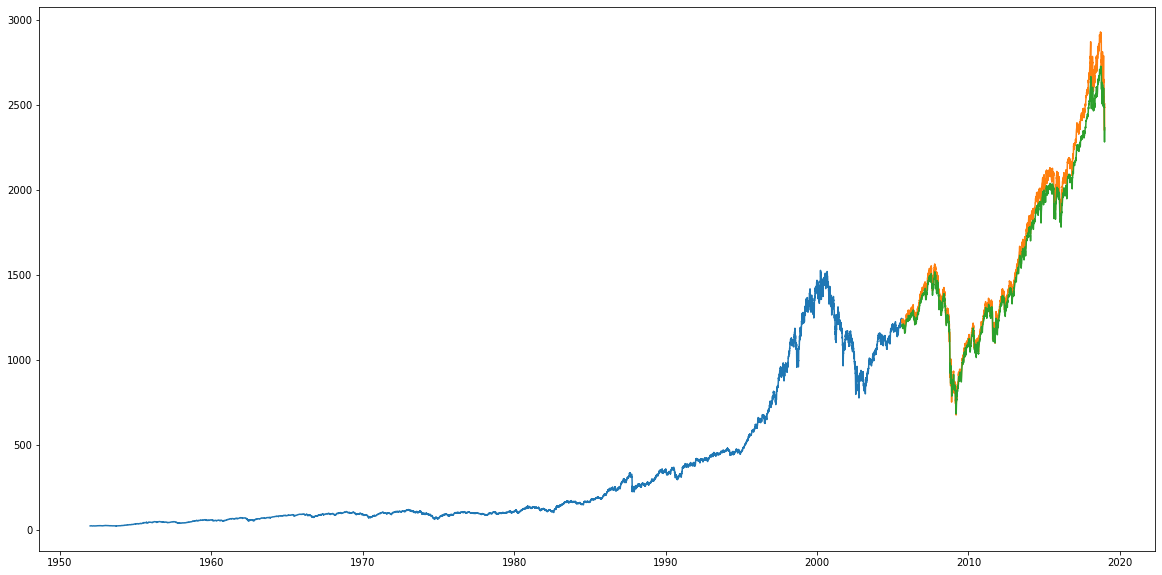

In [22]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
11.772259608962642
#for plotting
train = new_data[:13491]
valid = new_data[13491:]
valid['Predictions'] = closing_price
plt.plot(train['CLOSE'])
plt.plot(valid[['CLOSE','Predictions']])